# Basketball-Reference Scraper Overview
The following code will walk you through how to scrape NBA player and game data from www.basketball-reference.com and input it into a Pandas database. In other scripts within this directory, we will be using the data captured here to run analyses that will help the average user ask both broad and specific questions related to the NBA. We will probe on what statistics and criteria are important for an NBA team to win an NBA championship, how the league has evolved year-over-year, touch on the GOAT debate, and ultimately, build algorithms that can (hopefully) help us all beat Vegas lines consistently so that we can all retire from our day jobs and gamble on the NBA for the rest of our careers. 

None of this could have been done without the tireless and comprehensive effort of those who work at [Basketball Reference](http://www.basketball-reference.com) providing an open-source, API-friendly database containing millions of datapoints from which the entirety of this codebase is built. 

For any questions/concerns, feel free to reach out to me directly at rahim.hashim@columbia.edu. And in the case that this is useful to anyone for future projects, please give credit where credit is due, both to [Basketball Reference](http://www.basketball-reference.com) and myself. Enjoy!

***
## The Basics
__Jupyter Notebook__: All of the following code is hosted in a Python 3 Jupyter Notebook. It is recommended to use Anaconda to access the Notebook in order to have synchronously have access to all Python Libraries used in the rest of the code. 

In order to execute and compile code in the notebook, go to the desired code box and press _Shift_ + _Enter_ at the same time. All code below is recommended to be executed from top to bottom in order.

__Python Libraries__: Python is a beautiful language for a number of reasons, one of which is it's immense
amount of pre-built libraries that do much of the heavy lifting in any web-scraping /
data analysis project. When getting familiar with Python and starting a new project, be
sure to look through the internet for a Python library that may help. A comprehensive list
that I often refer to before starting a project is here: [https://github.com/vinta/awesome-python](https://github.com/vinta/awesome-python)

__Installing Libraries__: In case you receive an error upon trying to execute the following box, such as _ModuleNotFoundError: No module named 'numpy'_, go back to your terminal and open a new tab, and install the library using pip: _pip install numpy_

In [1]:
%reload_ext autoreload
import re
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict, defaultdict
pd.options.mode.chained_assignment = None  # default='warn'

ROOT = '/content/drive/MyDrive/Projects/nba-prediction-algorithm/NBA-Prediction-Algorithms/'

# add (non-Python) helper functions
def add_helpers():
  '''
  add_helper mounts google drive and adds
  helper functions to the sys.path
  '''

  # if running on juypter/google colab, mount to google drive
  if 'google.colab' in str(get_ipython()): 
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd drive/MyDrive/Projects/nba-prediction-algorithm/NBA-Prediction-Algorithms/

  helper_dir_path = ROOT + 'helper/'
  print('\nHelpers:')
  pprint(sorted(os.listdir(helper_dir_path)))
  sys.path.append(helper_dir_path) # set to path of notebook

add_helpers()

Mounted at /content/drive
/content/drive/MyDrive/Projects/nba-prediction-algorithm/NBA-Prediction-Algorithms

Helpers:
['Regions.py',
 'TeamNames.py',
 '__pycache__',
 'bettingLinesScraper.py',
 'gameLogScraper.py',
 'meta_info_scraper.py',
 'player_info_scraper.py',
 'player_scraper.py',
 'player_table_scraper.py',
 'seasonScraper.py',
 'teamsScraper.py']


***
## Creating Databases
Pandas databases are a powerful tool to query large amounts of data, as we will be doing here. For that reason, we are going to insert all of the data scraped above into a Pandas database. The below code will take player overview data from playerHash and insert it into player_df<br>
>For documentation on pandas: https://pypi.org/project/pandas/

***
## Scraping Player Data
### Biometrics and season + career statistics

playerScraper and metaDataScraper will be doing most of the work to scrape data on each player's background and physical attributes.<br>
> Example Overview Source (last name starting with a): https://www.basketball-reference.com/players/a/<br>
> Example meta-data (Karim Abdul-Jabbar): https://www.basketball-reference.com/players/a/abdulka01.html<br>
> For documentation on requests(): https://realpython.com/python-requests/<br>
> For documentation on BeautifulSoup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

___Time Estimates:___ This is the most computationally-intensive function in the program, requiring many url requests in order to complete.<br>
>*Without threading:* ~1hr<br>
>*With threading:* ~15min<br>

In [2]:
from player_scraper import scrape_all_players

ROOT = '/content/drive/MyDrive/Projects/nba-prediction-algorithm/NBA-Prediction-Algorithms/'
df_players_meta, df_players_data = scrape_all_players(ROOT, THREAD_FLAG=True)

players_df_meta.pkl and players_df_data.pkl already exists
  Uploading...
  Size (meta info): 4.6MB
  Size (player data): 1.3GB
Complete.


***
## Example Queries (Simple)

The following are example queries we can make across all of the generated tables. As can be seen below, the structure of the DataFrame allows for immense flexibility and speed gains as compared to looking at the website itself. We will utilize this structure for more specific trend-, team-, and era- related investigations.

In [3]:
df_players_meta.head(0)

,player_name,draft_year,retire_year,height,weight,birth_date,college,birthCountry,birthCity,birthState,shootingHand,highSchool,highSchoolCity,highSchoolState,highSchoolCountry,draftTeam,draftRound,draftRoundPick,draftOverallPick


In [4]:
# Player Meta Query
df_large = df_players_meta.loc[(df_players_meta['height']>80) & 
                   (df_players_meta['weight']>30)]

df_large = df_large.dropna(how='all', axis='columns') # drops all columns that are empty
display(df_large[df_large['weight'] == df_large['weight'].max()])

,player_name,draft_year,retire_year,height,weight,birth_date,college,birthCountry,birthCity,birthState,shootingHand,highSchool,highSchoolCity,highSchoolState,highSchoolCountry,draftTeam,draftRound,draftRoundPick,draftOverallPick
0,Sim Bhullar,2015,2015,89,360,"December 2, 1992",New Mexico State,Canada,Ontario,NaN,Right,Huntington Prep,Huntington,West Virginia,United States of America,NaN,NaN,NaN,NaN


In [9]:
df_players_data.head(5)

,data_type,season_playoffs,player_name,season,age,team_id,lg_id,pos,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,ft_per_g,fta_per_g,ft_pct,trb_per_g,ast_per_g,pf_per_g,pts_per_g,mp,fg,fga,ft,fta,trb,ast,pf,pts,per,ts_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,DUMMY,ows,dws,...,blk_per_mp,tov_per_mp,fg_per_poss,fga_per_poss,fg3_per_poss,fg3a_per_poss,fg2_per_poss,fg2a_per_poss,ft_per_poss,fta_per_poss,orb_per_poss,drb_per_poss,trb_per_poss,ast_per_poss,stl_per_poss,blk_per_poss,tov_per_poss,pf_per_poss,pts_per_poss,,off_rtg,def_rtg,info,header_pos_estimates,header_plus_minus,header_turnovers,header_fouls,header_drawn,header_misc2,zzz,pct_fga,fg_pct_dist,pct_ast,dunks,corner3,heaves,college_id,team_name,salary,trp_dbl
0,game,season,Joe Fabel,1946-47,29.0,PIT,BAA,NaN,30.0,NaN,NaN,0.8,3.2,.260,0.4,0.9,.500,NaN,0.1,2.1,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,game,season,Joe Fabel,Career,NaN,NaN,BAA,NaN,30.0,NaN,NaN,0.8,3.2,.260,0.4,0.9,.500,NaN,0.1,2.1,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,season,Joe Fabel,1946-47,29.0,PIT,BAA,NaN,30.0,NaN,NaN,NaN,NaN,.260,NaN,NaN,.500,NaN,NaN,NaN,NaN,NaN,25.0,96.0,13.0,26.0,NaN,2.0,64.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,season,Joe Fabel,Career,NaN,NaN,BAA,NaN,30.0,NaN,NaN,NaN,NaN,.260,NaN,NaN,.500,NaN,NaN,NaN,NaN,NaN,25.0,96.0,13.0,26.0,NaN,2.0,64.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,season,Joe Fabel,1946-47,29.0,PIT,BAA,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.293,.271,NaN,NaN,NaN,NaN,NaN,-0.1,-0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Player Data Query
df_career = df_players_data.loc[(df_players_data['season']=='Career') & 
                   (df_players_data['season_playoffs']=='season') &
                   (df_players_data['data_type']=='advanced')]

df_career = df_career.dropna(how='all', axis='columns')
display(df_career.sort_values('ws_per_48', ascending=False))

,data_type,season_playoffs,player_name,season,lg_id,g,mp,per,ts_pct,fta_per_fga_pct,orb_pct,drb_pct,trb_pct,ast_pct,ows,dws,ws,ws_per_48,fg3a_per_fga_pct,stl_pct,blk_pct,tov_pct,usg_pct,obpm,dbpm,bpm,vorp
20,advanced,season,John Stroeder,Career,NBA,1.0,1,122.4,1.500,.000,0.0,0.0,0.0,0.0,0.1,0.0,0.1,2.546,1.000,0.0,0.0,0.0,42.0,84.3,14.3,98.6,0.0
35,advanced,season,Jordan McRae,Career,NBA,2.0,4,110.5,1.125,.000,0.0,58.2,29.5,0.0,0.2,0.0,0.2,1.896,.250,0.0,0.0,0.0,46.2,42.8,15.0,57.8,0.1
14,advanced,season,Malcolm Delaney,Career,NBA,1.0,3,105.5,1.031,.667,0.0,37.5,18.7,0.0,0.1,0.0,0.1,1.801,.333,0.0,0.0,0.0,54.8,39.0,13.0,52.0,0.0
23,advanced,season,Isaiah Hartenstein,Career,NBA,2.0,2,98.0,1.000,.000,58.2,0.0,28.2,0.0,0.1,0.0,0.1,1.594,.000,0.0,0.0,0.0,43.9,23.6,2.2,25.8,0.0
17,advanced,season,Connie Norman,Career,NBA,1.0,1,83.1,1.000,.000,0.0,100.0,54.4,0.0,0.0,0.0,0.0,1.591,NaN,0.0,0.0,NaN,NaN,31.8,16.1,47.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,advanced,season,Max Morris,Career,NBA,3.0,NaN,NaN,.418,.650,NaN,NaN,NaN,NaN,0.1,0.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,advanced,season,George Munroe,Career,BAA,6.0,NaN,NaN,.475,.250,NaN,NaN,NaN,NaN,0.7,0.1,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,advanced,season,Jack Burmaster,Career,NBA,3.0,NaN,NaN,.549,.129,NaN,NaN,NaN,NaN,0.4,0.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,advanced,season,Angelo Musi,Career,BAA,25.0,NaN,NaN,.298,.193,NaN,NaN,NaN,NaN,-0.3,1.4,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
## Single Player Queries

If you don't need to scrape the entire basketball-reference website but instead just want information for one player, you can use the following command.

In [ ]:
from player_info_scraper import player_info_scraper
from player_scraper import scrape_single_player

pd.set_option('display.max_rows', None)
single_player_info, single_player_df = scrape_single_player()
single_player_df

***
## Scraping Game Data
### Game-logs and team statistics

In [ ]:
# WIP

***
## Data Organization
To help us understand how all the data is organized, here's a visual:

In [10]:
df_career = df_players_data.loc[(df_players_data['season']=='Career') & 
                   (df_players_data['season_playoffs']=='season') &
                   (df_players_data['data_type']=='advanced')]

df_career.dropna(axis='columns')

,data_type,season_playoffs,player_name,season,lg_id,g,ows,dws,ws
14,advanced,season,Joe Pace,Career,NBA,9.0,0.2,0.1,0.3
17,advanced,season,Fred LaCour,Career,NBA,5.0,0.0,0.0,0.0
14,advanced,season,Zhou Qi,Career,NBA,3.0,0.0,0.0,0.0
26,advanced,season,Stephen Vacendak,Career,ABA,14.0,0.5,0.2,0.7
14,advanced,season,Charles O'Bannon,Career,NBA,4.0,-0.1,0.0,-0.1
...,...,...,...,...,...,...,...,...,...
62,advanced,season,Pete Myers,Career,NBA,24.0,0.1,0.2,0.3
53,advanced,season,Andrew Bynum,Career,NBA,74.0,3.3,1.9,5.2
35,advanced,season,Will Bynum,Career,NBA,7.0,0.0,0.1,0.1
26,advanced,season,Marty Byrnes,Career,NBA,4.0,0.0,0.0,0.0


***
## Meta-Data Analysis
Now that we've scraped all the meta-info on each player, we can start running analyses.

Below, a few simple analyses are included to help you get started. The first set of graphs examine height distribution (left), weight distribution (middle), and shooting handedness (right).

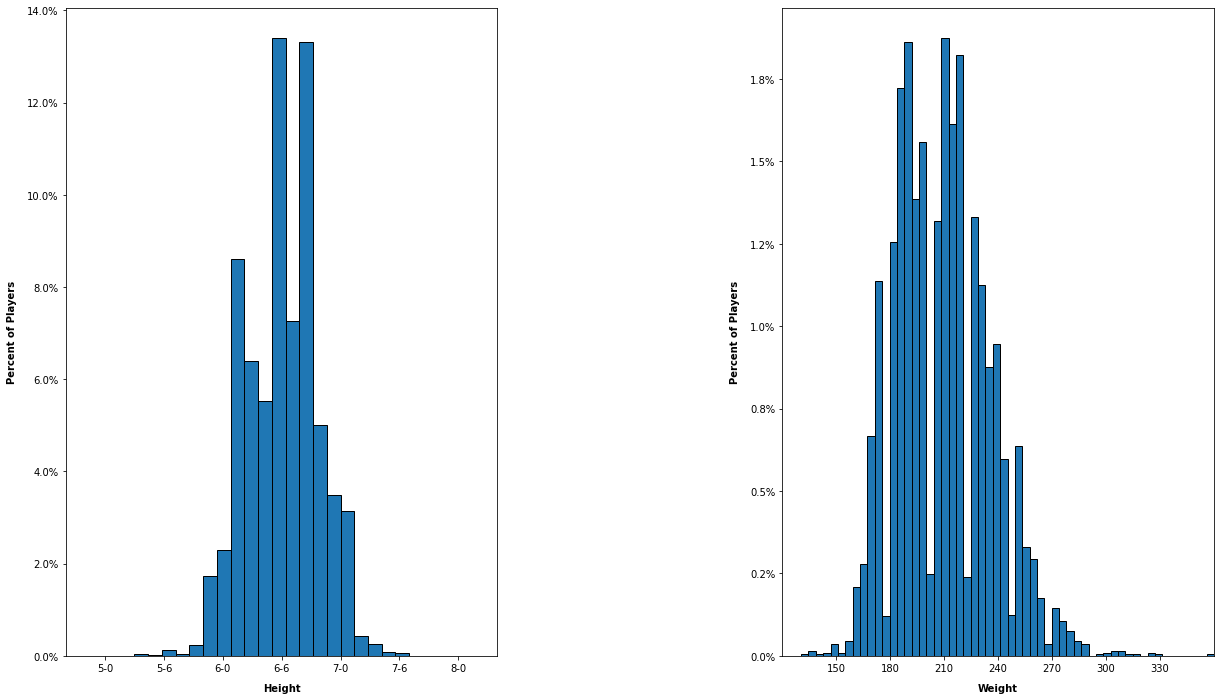

In [11]:
from Regions import stateDict #stateDict is a Dictionary to help with geography-based analyses
def metaPlot():
  
  height_list = df_players_meta['height'].tolist()
  weight_list = df_players_meta['weight'].tolist()
  #rightCount = 0; leftCount = 0; noHandCount = 0

  #Plot Height Distribution (1, Left)
  f, ax = plt.subplots(1,2)
  #Sets default plot size
  plt.rcParams['figure.figsize'] = (10,8)
  n1, bins1, patches1 = ax[0].hist(height_list, bins=20, density=True, histtype='bar', ec='black')
  #Converting y-axis labels from decimals to percents
  y_vals = ax[0].get_yticks(); ax[0].set_yticklabels(['{:3.1f}%'.format(y*100) for y in y_vals])
  #Converting x-axis labels from inches back to feet
  xticks1 = ['5-0', '5-6', '6-0', '6-6', '7-0', '7-6', '8-0']
  ax[0].set_xticks([60, 66, 72, 78, 84, 90, 96])
  ax[0].set_xticklabels(xticks1)
  ax[0].set_xlim([56,100])
  ax[0].set_xlabel('Height', fontweight='bold', labelpad=10)
  ax[0].set_ylabel('Percent of Players', fontweight='bold', labelpad=10)

  #Plot Weight Distribution (1, Middle)
  ax[1].hist(weight_list, bins='auto', density=True, histtype='bar', ec='black')
  y_vals = ax[1].get_yticks()
  ax[1].set_yticklabels(['{:3.1f}%'.format(y*100) for y in y_vals])
  xticks2 = ['150', '180', '210', '240', '270', '300', '330']
  ax[1].set_xticks([150, 180, 210, 240, 270, 300, 330])
  ax[1].set_xticklabels(xticks2)
  ax[1].set_xlim([120,360])
  ax[1].set_xlabel('Weight', fontweight='bold', labelpad=10)
  ax[1].set_ylabel('Percent of Players', fontweight='bold', labelpad=10)
  
  plt.tight_layout(pad=0.05, w_pad=4, h_pad=1.0)
  f.set_size_inches(18.5, 10.5, forward=True)
  plt.show()
        
metaPlot()

odict_keys(['Canada', 'France', 'Serbia', 'Germany', 'Australia', 'Croatia', 'Brazil', 'Spain', 'Argentina', 'Lithuania', 'Bosnia and Herzegovina', 'Nigeria', 'Senegal', 'Slovenia', 'United Kingdom', 'Russia', 'Italy', 'Greece', 'Ukraine', 'Puerto Rico', 'Turkey', 'China', 'Jamaica', 'Dominican Republic', 'Latvia', 'Netherlands', 'Montenegro', 'South Sudan', 'Democratic Republic of the Congo', 'Bahamas', 'Haiti', 'Switzerland', 'Czech Republic', 'Mexico', 'Panama', 'New Zealand', 'Israel', 'Cameroon', 'Japan', 'Sweden', 'Poland', 'Belgium', 'Guadeloupe', 'U.S. Virgin Islands', 'Cuba', 'Egypt', 'Sudan', 'Mali', 'French Guiana', 'Venezuela', 'Lebanon', 'Gabon', 'Macedonia', 'Finland', 'Guyana', 'Guinea', 'Romania', nan, nan, nan, nan, nan, 'Iran', nan, nan, nan, 'Republic of the Congo', nan, nan, nan, nan, nan, nan, nan, nan, nan, 'Cape Verde', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'South Africa', nan, nan, nan, nan, nan, nan, 'Ang

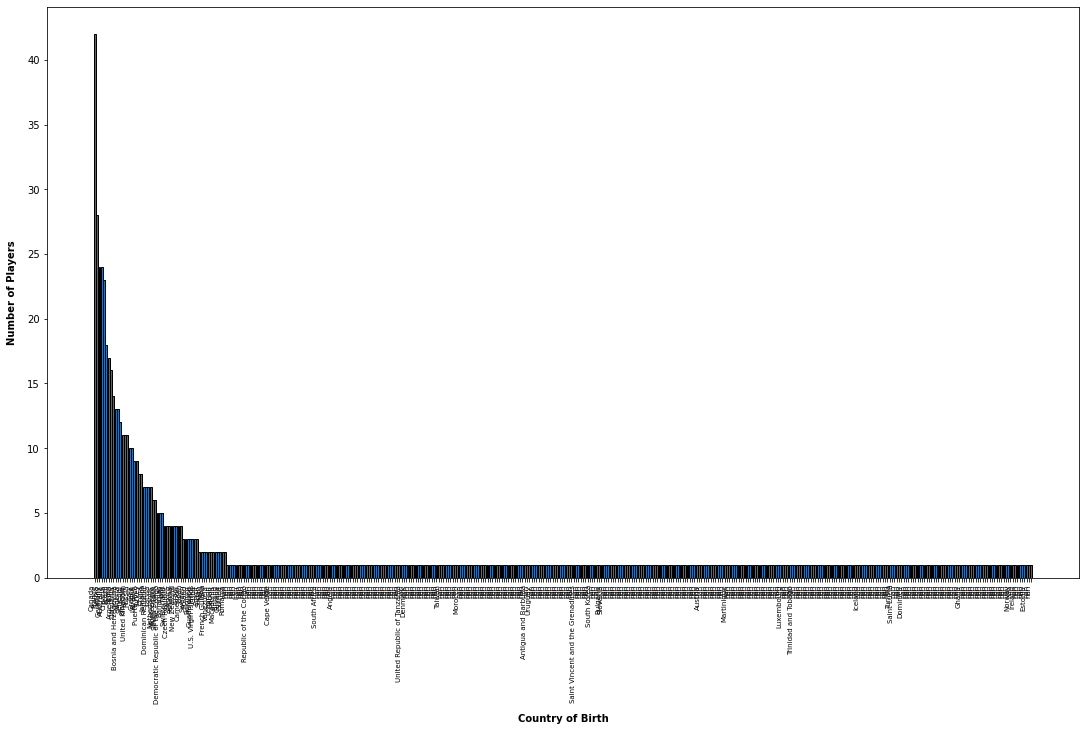

In [12]:
def geographyPlot():
  countryList = df_players_meta['birthCountry'].tolist()
  #countryList contains all players born in ex-US
  countryList = filter(lambda x: x != 'United States of America', countryList)
  countryList = filter(lambda x: x != '', countryList)
  countryHash = dict(Counter(countryList))
  countryHash = OrderedDict(sorted(countryHash.items(), reverse=True, key=lambda t: t[1]))

  pprint(countryHash.keys())

  #Plot Birth Countries of non-US-Born Players (3)
  f, ax = plt.subplots(1)
  countryList = countryHash.keys(); countryVals = countryHash.values()
  ax.bar(np.arange(len(countryList)), countryVals, ec='black')
  ax.set_xticks(np.arange(len(countryList)))
  ax.set_xticklabels(countryList, rotation=90, ha='right', fontsize=7)
  ax.set_xlabel('Country of Birth', fontweight='bold', labelpad=10)
  ax.set_ylabel('Number of Players', fontweight='bold', labelpad=10)
  
  f.set_size_inches(18.5, 10.5, forward=True)
  plt.show()
    
geographyPlot()